In [1]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,confusion_matrix

import numpy as np
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import tensorflow_datasets as tfds
import pandas as pd

import sklearn as sk
import os
import nltk
from nltk.data import find

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import re
from sklearn.utils import class_weight

from keras.layers import Concatenate, Dense, LSTM, Input, concatenate

2022-12-01 11:46:39.583500: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-01 11:46:39.836227: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-01 11:46:40.938906: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-01 11:46:40.939156: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

In [2]:
from transformers import BertTokenizer, TFBertModel
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
bert_model = TFBertModel.from_pretrained('bert-base-cased')

# bring in the data
questions_data = pd.read_csv("questions_nb_predictions.csv")

2022-12-01 11:46:44.814844: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-12-01 11:46:44.852720: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-12-01 11:46:44.852745: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-12-01 11:46:44.853560: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep

In [3]:
train = questions_data.loc[questions_data['SPLIT'] == "TRAIN"]
test = questions_data.loc[questions_data['SPLIT'] == "TEST"]

In [4]:
train_titles = list(train['Title'])
train_nb_preds = list(train['NB_prediction'])
train_labels = list(train['has_positive_answer'])

test_titles = list(test['Title'])
test_nb_preds = list(test['NB_prediction'])
test_labels = list(test['has_positive_answer'])

In [5]:
cv = CountVectorizer(stop_words='english',min_df=0.008)

train_cv = cv.fit_transform(train_titles).todense()
test_cv = cv.transform(test_titles).todense()

cv_vocab_size = len(cv.vocabulary_)
cv_vocab_size

93

In [6]:
train_cv = tf.convert_to_tensor(train_cv)
test_cv = tf.convert_to_tensor(test_cv)

In [7]:
max_length = 30 # seems like this encompasses most titles

In [8]:
# train data
x_train = bert_tokenizer(train_titles,
              max_length=max_length,
              truncation=True,
              padding='max_length', 
              return_tensors='tf')
x_train_nb = tf.convert_to_tensor(train_nb_preds)
y_train = tf.convert_to_tensor(train_labels)


# test data
x_test = bert_tokenizer(test_titles,
              max_length=max_length,
              truncation=True,
              padding='max_length', 
              return_tensors='tf')
x_test_nb = tf.convert_to_tensor(test_nb_preds)
y_test = tf.convert_to_tensor(test_labels)

In [9]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train.numpy()), y=y_train.numpy())
class_weights_dict = {}
for i in range(0,2):
    class_weights_dict[i] = class_weights[i]
class_weights_dict

{0: 1.5165523114856558, 1: 0.7459293015965245}

In [12]:
def build_bert_count_vector_model(bert_model,
                                     learning_rate=0.00005):
    
    bert_model.trainable = False

    # 3 BERT input layers
    input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}      
    bert_out = bert_model(bert_inputs)
    
    pooled_token = bert_out[1]
    
    # first concatenate the count vector w/ pooled token, prior to dense layer
    
    # concatenate count vector layer (this needs to be the size of the CV vector, which is the # words in the CV vocab)
    count_vector_layer = tf.keras.layers.Input(shape=(cv_vocab_size,), dtype=tf.float32, name='count vector layer')
    
    concatenated_layers = concatenate([pooled_token, count_vector_layer])
    
    # concatenate the raw NB prediction
    nb_prediction_layer = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='nb_prediction_layer')
    
    concatenated_layers = concatenate([concatenated_layers, nb_prediction_layer])
    
    # after concatenating, put through large dense layer
    
    dense_layer = tf.keras.layers.Dense(500, activation='relu', name='hidden_layer')(concatenated_layers)
    
    dropout = tf.keras.layers.Dropout(0.3)(dense_layer)  

    classification = tf.keras.layers.Dense(1, activation='sigmoid',name='classification_layer')(dropout)
    
    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask, count_vector_layer, nb_prediction_layer], outputs=[classification])
    
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), 
                                 metrics='accuracy')
    
    return classification_model

In [13]:
bert_classification_model = build_bert_count_vector_model(bert_model)

In [14]:
bert_classification_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 30)]        0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 30)]         0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 30)]        0           []                               
 er)                                                                                              
                                                                                              

In [15]:
bert_classification_model_history = bert_classification_model.fit(
    [x_train.input_ids, x_train.token_type_ids, x_train.attention_mask, train_cv, x_train_nb],
    y_train,
    validation_data=([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask, test_cv, x_test_nb], y_test),
    batch_size=25,
    epochs=2,
    class_weight=class_weights_dict
)

Epoch 1/2
17665/17665 [==============================] - 13300s 751ms/step - loss: 0.6536 - accuracy: 0.6166 - val_loss: 0.6210 - val_accuracy: 0.6569
Epoch 2/2
17665/17665 [==============================] - 8486s 480ms/step - loss: 0.6367 - accuracy: 0.6474 - val_loss: 0.6244 - val_accuracy: 0.6561


In [16]:
   y_pred_raw = bert_classification_model.predict([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask, test_cv, x_test_nb])
y_pred = (y_pred_raw > 0.5).astype(int)

5178/5178 [==============================] - 2105s 406ms/step


In [17]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)

group_names = ["True Neg", "False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]



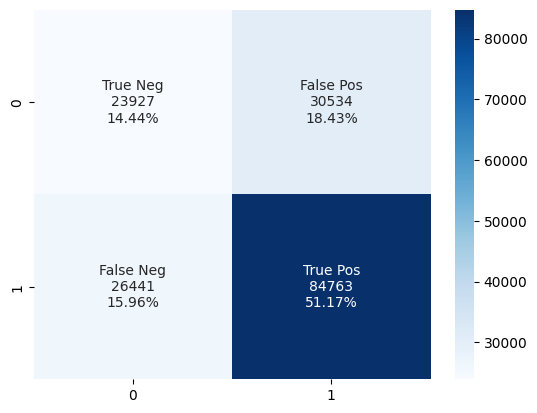

In [18]:
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, fmt="", cmap='Blues', annot=labels)

from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_raw)
auc = metrics.roc_auc_score(y_test, y_pred_raw)

In [22]:
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
print(specificity)

0.43934191439745873


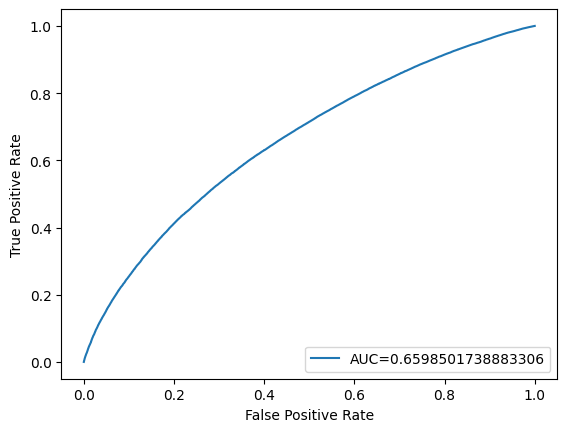

In [19]:
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [20]:
from sklearn.metrics import f1_score, precision_score, recall_score
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"f1 score is: {f1}")
print(f"precision score is: {precision}")
print(f"recall score is: {recall}")

f1 score is: 0.7484558567070344
precision score is: 0.7351709064416246
recall score is: 0.7622297759073414
